# カルマンフィルタの勉強(ローカルレベルモデル)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import numpy as np
import math

## 事前準備

予測を行う関数を準備

In [2]:
def create_random_walk(n, v, w):
    """ランダムウォークの真値と観測データを生成
    
    ランダムウォークの真値と観測誤差入り観測データを生成

    Args:
        n(int): 生成するデータ数
        v(float): 変動誤差の分散
        w(float): 観測誤差の分散
    
    Returns:
        List[flot], List[flot]: 真値,観測データ
    """
    x = np.cumsum(np.random.normal(0.0, math.sqrt(v), n))
    y = x + np.random.normal(0.0, math.sqrt(w), n)
    return x, y

In [3]:
def predict_llm(x, x_var, y, v, w):
    """ローカルレベルモデルでの予測
    
    ローカルレベルモデルで計測値から次のデータを予測

    Args:
        x(float): 現在の予測値
        x_var(float): 現在の予測値の尤度の分散
        y(float): 新しい観測地
        v(float): 変動誤差の分散
        w(float): 観測誤差の分散

    Returns:
        flot, float, float: 新しい予測値、新しい予測値の尤度の分散値、尤度
    """
    
    # 現在値の予測
    predict_x     = x           # 期待値は前回の値のそのまま
    predict_x_var = x_var + v   # 分散を加算される
    
    # 尤度
    likelihood = scipy.stats.norm.pdf(y, loc=predict_x, scale=np.sqrt(predict_x_var + w))
    
    # カルマンゲインを計算
    kalman_gain = predict_x_var / (predict_x_var + w)
    
    # 計測値と合成
    next_x     = predict_x + kalman_gain * (y - predict_x)
    next_x_var = (1 - kalman_gain) * predict_x_var
    
    # 2変数の最適合成という点では上はこう書いても等価
#   next_x     = (w * predict_x +  predict_x_var * y) / (predict_x_var + w)
#   next_x_var = (predict_x_var * w) / (predict_x_var + w)
    
    return next_x, next_x_var, likelihood

In [5]:
def calc_predict(y, v, w):
    """ ローカルレベルモデルで計測値から予測を実施
    """
    n = len(y)
    x = np.ndarray(n)
    x_var = np.ndarray(n)
    likelihood = np.ndarray(n)
    x[0] = 0
    x_var[0] = 0
    likelihood[0] = 1.0
    for i in range(1, n):
        x[i], x_var[i], likelihood[i] = predict_llm(x[i-1], x_var[i-1], y[i], v, w)
    return x, likelihood

In [6]:
def calc_rmse(x_true, y, v, w):
    """ 予測値と真値のRMSEを計算してみる 
    """
    x, _ = calc_predict(y, v, w)
    return np.sqrt(np.mean((x - x_true)**2))

## データ生成

In [7]:
# テストデータ生成(これを真値とする)
v_true = 2.0  # 変動誤差の分散(後で推定したい定数1)
w_true = 5.0  # 観測誤差の分散(後で推定したい定数2)
x_true, y = create_random_walk(1000, v_true, w_true)

RMSE = 1.475455


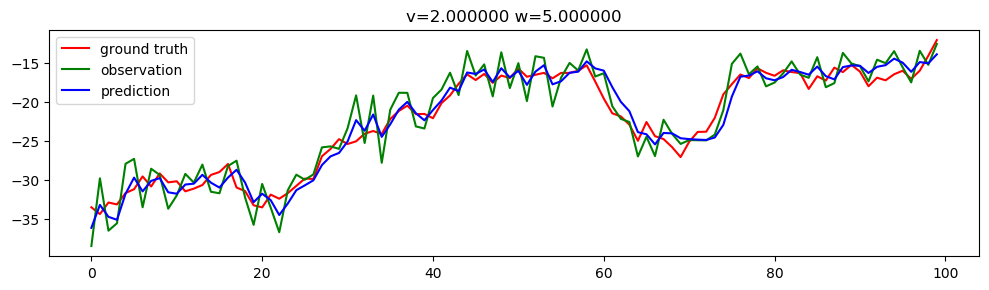

In [8]:
# ためしに誤差の分散が機知の前提で推定してみる
x, likelihood = calc_predict(y, v_true, w_true)
print('RMSE = %f' % calc_rmse(x_true, y, v_true, w_true))

# 最後の100個を表示
plt.figure(figsize=(12, 3), dpi=100)
plt.title('v=%f w=%f' % (v_true, w_true))
plt.plot(x_true[900:1000], c='red', label='ground truth')
plt.plot(y[900:1000], c='green', label='observation')
plt.plot(x[900:1000], c='blue', label='prediction')
plt.legend()
plt.savefig('plot.png')
plt.show()

## パラメータ推定
  観測値から誤差の分散を予測する


In [11]:
def minimize_likelihood(x):
    """ scipy.optimize の関数
        分散は負の値を取らないので exp して使う
    """
    _, likelihood = calc_predict(y, np.exp(x[0]), np.exp(x[1]))
    return -np.sum(np.log(likelihood))  # 尤度最大化したいので符号を反転させる

In [15]:
# 予測実施
result = scipy.optimize.minimize(minimize_likelihood, x0=[1.0, 1.0], method="L-BFGS-B")

v_predict = np.exp(result.x[0])
w_predict = np.exp(result.x[1])
print('v_predict = %f (v_true = %f)' % (v_predict, v_true))
print('w_predict = %f (w_true = %f)' % (w_predict, w_true))
print('RMSE = %f' % calc_rmse(x_true, y, v_predict, w_predict))

v_predict = 1.912540 (v_true = 2.000000)
w_predict = 4.820338 (w_true = 5.000000)
RMSE = 1.475380


# x_trueが既知の前提で計算してみる

In [18]:
def minimize_mse(x):
    """ scipy.optimize の関数
    """
    x, likelihood = calc_predict(y, np.exp(x[0]), np.exp(x[1]))
    return np.mean((x - x_true)**2)  # Mean Square Error を返す

In [19]:
result = scipy.optimize.minimize(minimize_mse, x0=[1.0, 1.0], method="L-BFGS-B")

v_predict = np.exp(result.x[0])
w_predict = np.exp(result.x[1])
print('v_predict = %f (v_true = %f)' % (v_predict, v_true))
print('w_predict = %f (w_true = %f)' % (w_predict, w_true))
print('RMSE = %f' % calc_rmse(x_true, y, v_predict, w_predict))

v_predict = 1.681320 (v_true = 2.000000)
w_predict = 4.394796 (w_true = 5.000000)
RMSE = 1.475229


# 以下、残骸

In [13]:
minimize_func([np.log(1.0), np.log(5.0)])

2415.5784304955896

In [14]:
minimize_func([np.log(1.0), np.log(4.0)])

2417.247699626749

In [15]:
minimize_func([np.log(1.0), np.log(3.0)])

2445.562266824506

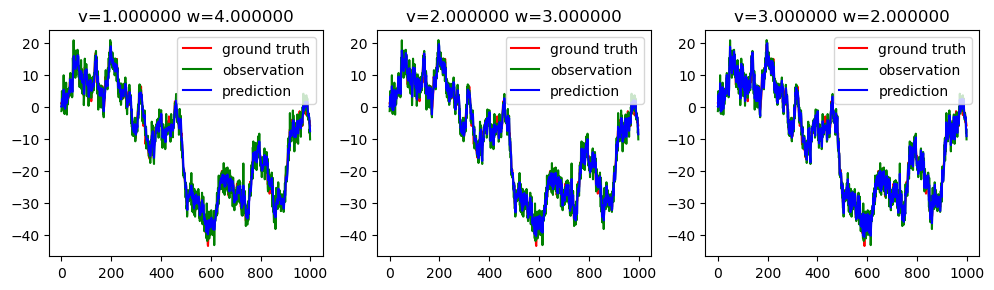

In [26]:
# 分散を変えて計算してみる
v_test = [1.0, 2.0, 3.0]
w_test = [4.0, 3.0, 2.0]
n = 3

list_x = []
list_x_var = []
list_l = []
for i in range(n):
    x, x_var, l = calc_predict(y, v_test[i], w_test[i])
    list_x.append(x)
    list_x_var.append(x_var)
    list_l.append(l)
    
fig = plt.figure(figsize=(12, 3), dpi=100)
for i in range(n):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('v=%f w=%f' % (v_test[i], w_test[i]))
    ax.plot(x_true, c='red', label='ground truth')
    ax.plot(y, c='green', label='observation')
    ax.plot(list_x[i], c='blue', label='prediction')
    ax.legend()

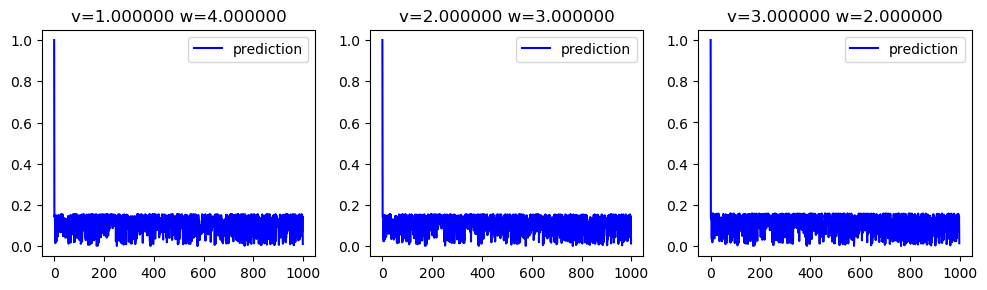

In [8]:
fig = plt.figure(figsize=(12, 3), dpi=100)
for i in range(n):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('v=%f w=%f' % (v_test[i], w_test[i]))
    ax.plot(list_l[i], c='blue', label='prediction')
    ax.legend()